# drosophila_simulation

> Create initial conditions for a "germ band", and run simulations with patterned mechanical feedback.

Having defined mesh data structure, tension triangulation time evolution and primal cell shape optimization, we  now turn to the specific type of simulation we want to run: idealized versions of the _Drosophila_ "germ band".

We show how to create the required initial conditions, add some more helper functions for intercalation handling, and examples of how to analyze a simulation, building on the `02_delaunay_simulation` notebook.

In [ ]:
#| default_exp drosophila

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso)

<module 'CE_simulation.isogonal' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/isogonal.py'>

### Self-documentation

Function to save a notebook to the directory where you save simulation results, so you know what code you were running.

In [ ]:
#| export

import time as time_module # so you don't accidentally overwrite the name 'time' with a variable

def save_self(save_dir, fname='04a_drosophila_simulation_experimentation.ipynb'):
    """Save a copy of current python file to a directory, with a time stamp"""
    nbname = os.getcwd()+'/'+fname
    copied_script_name = time_module.strftime("%Y-%m-%d_%H%M") + '_' + os.path.basename(nbname)
    shutil.copy(nbname, save_dir + os.sep + copied_script_name)

## Initial condition creation

In notebook `02_delaunay_simulation` we have already seen how to create some initial conditions, based on triangular lattice patches. However, in the simulations we wish to carry out, we need to specify some more data:

- Boundary conditions
- Active and passive regions
- Plotting helpers, e.g. initial row of each cell

We present and additional routine for initial condition creation, more specific to the _Drosophila_ germ band simulations we plan to carry out.  

In [ ]:
#| export

## colors for cell rows -  from Fridtjof

fridtjof_colors = np.array([[0.34398, 0.49112, 0.89936],
                            [0.97, 0.606, 0.081],
                            [0.91, 0.318, 0.243],
                            [0.448, 0.69232, 0.1538],
                            [0.62168, 0.2798, 0.6914],
                            [0.09096, 0.6296, 0.85532],
                            [0.46056, 0.40064, 0.81392],
                            [0.94, 0.462, 0.162],
                            [0., 0.7, 0.7],
                            [0.827051, 0.418034, 0.0243459],
                            [0.5511749434976025, 0.32014794962639853, 0.8720626412559938],
                            [0.72694101250947, 0.7196601125010522, 0.],
                            [0.8680706456216862, 0.2563858708756628, 0.30321559063052295],
                            [0.2418693812442152, 0.5065044950046278, 0.9902432574930582],
                            [0.9573908706237908, 0.5369543531189542, 0.11504464931576472]])

fridtjof_colors_new = ["#e8513eff", "#e6e6e6ff",
                       "#f79b15ff", "#e6e6e6ff",
                       "#72b127ff", "#e6e6e6ff",
                       "#17a1daff", "#e6e6e6ff",
                       "#9f47b0ff", "#e6e6e6ff"]
fridtjof_colors_new = np.array([mpl.colors.to_rgb(x) for x in fridtjof_colors_new])

In [ ]:
#| export

def create_rect_initial(nx, ny, noise=0, initial_strain=0, isogonal=0, orientation='orthogonal',
                        boundaries=None, w_passive=0, w_passive_lr=0, bdry_x=None, bdry_y=None,
                        random_seed=0):
    """
    Create initial condition for germ band simulations.
    
    Creates a CellHalfEdgeMesh from a rectangulat patch of triangular lattice, creates boundary conditions,
    selects active and passive triangles, creates a dictionary with the initial rows of active cells,
    and sets edge rest lengths and cell rest shapes.
    
    Random seed for noise can be specified for reproducible results.
    
    Parameters
    ----------
    nx, ny: int
        Width and height of rectangular patch
    noise: float
        Standard deviation of the noise added to the initial vertex positions
    initial_strain: float
        Initial y-axis strain applied to tension triangulation. Applies transform matrix
        diag(1/(1+s), 1+s)
    orientation: 'orthogonal' or 'parallel'
        Orientation of hexagonal lattice direction w.r.t. y-axis.
    boundaries: list of 'top', 'bottom', 'left', 'right'
        On which sides to add slip walls.
    w_passive: float
        Width of passive region on the top and bottom
    w_passive_lr: float
        Width of passive region on the left and right
    bdry_x, bdry_y: float
        Location of the the left/right and top/bottom slip walls. If None, set to initial mesh positions
    random_seed: int
        Numpy random number generator seed.
        
    """
    np.random.seed(random_seed)
    # create the mesh
    if orientation == 'parallel':
        nx, ny = (ny, nx)
    mesh_initial = iso.CellHalfEdgeMesh(dln.create_rect_mesh(ny, nx, noise=noise, defects=(0, 0),
                                                             straight_bdry=False))
    if orientation == 'orthogonal':
        mesh_initial.transform_vertices(dln.rot_mat(np.pi/2))
    center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
    mesh_initial.transform_vertices(lambda x: x-center)
    mesh_initial.set_voronoi()
    
    mesh_initial.transform_vertices(dln.shear_mat(1+initial_strain))
    mesh_initial.set_rest_lengths()
    
    # create the boundary conditions
    boundaries = [] if boundaries is None else boundaries
    bdry_list = []
    max_x_cells = np.max([v.get_centroid()[0] for v in mesh_initial.vertices.values() if not v.is_bdry()])
    max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

    bdry_x = np.ceil(max_x_cells) if bdry_x is None else bdry_x
    bdry_y = np.ceil(max_y_cells) if bdry_y is None else bdry_y
    
    w_bdry = .4
    
    if 'top' in boundaries:
        top_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
                top_ids.append(v._vid)
        def top_penalty(x):
            return (x[1]-bdry_y)**2
        top_penalty = Partial(jit(top_penalty))
        bdry_list.append([top_penalty, top_ids])

    if 'bottom' in boundaries:
        bottom_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
                bottom_ids.append(v._vid)
        def bottom_penalty(x):
            return (x[1]+bdry_y)**2
        bottom_penalty = Partial(jit(bottom_penalty))
        bdry_list.append([bottom_penalty, bottom_ids])
        
    if 'left' in boundaries:
        left_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] < -(max_x_cells-w_bdry)) and (not v.is_bdry()):
                left_ids.append(v._vid)
        def left_penalty(x):
            return (x[0]+bdry_x)**2
        left_penalty = Partial(jit(left_penalty))
        bdry_list.append([left_penalty, left_ids])

    if 'right' in boundaries:
        right_ids = []
        for v in mesh_initial.vertices.values():
            if (v.get_centroid()[0] > (max_x_cells-w_bdry)) and (not v.is_bdry()):
                right_ids.append(v._vid)
        def right_penalty(x):
            return (x[0]-bdry_x)**2
        right_penalty = Partial(jit(right_penalty))
        bdry_list.append([right_penalty, right_ids])    
    mesh_initial.bdry_list = bdry_list
        
    # set the active and passive triangles
    passive_faces = []
    max_y_faces = np.max([val.primal_coords[1] for val in mesh_initial.faces.values()])
    max_x_faces = np.max([val.primal_coords[0] for val in mesh_initial.faces.values()])

    for fc in mesh_initial.faces.values():
        if (fc.is_bdry()
            or (np.abs(fc.primal_coords[1]) > (max_y_faces-w_passive))
            or (np.abs(fc.primal_coords[0]) > (max_x_faces-w_passive_lr))):
            passive_faces.append(fc._fid)
            
    passive_faces = sorted(passive_faces)
    passive_edges = list(msh.flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_faces]))
    passive_cells = [v._vid for v in mesh_initial.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.faces])]

    # create dict of initial row ids
    if orientation == 'parallel':
        initial_row_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    elif orientation == 'orthogonal':
        initial_row_dict = {key: np.round(val.get_centroid()[1], decimals=0)
                            for key, val in mesh_initial.vertices.items()
                            if (not key in passive_cells) and (not val.is_bdry())}
    min_val = min(initial_row_dict.values())
    initial_row_dict = {key: int(val-min_val) for key, val in initial_row_dict.items()}
    
    # set isogonal mode for active cells.
    for v in mesh_initial.vertices.values():
        if v._vid in passive_cells:
            v.rest_shape = np.sqrt(3) * np.array([[1, 0],[0, 1]])
        else:
            v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    property_dict = {'initial_row_dict': initial_row_dict, 'passive_faces': passive_faces,
                     'passive_edges': passive_edges, 'passive_cells': passive_cells,
                     'bdry_x': bdry_x, 'bdry_y': bdry_y}
    
    return mesh_initial, property_dict

## Simulation with boundary conditions and passive & active cells

### Plot initial condition

In [ ]:
# create initial condition

mesh_initial, property_dict = create_rect_initial(24, 36, noise=0.1, initial_strain=0.1,
                                                  orientation='orthogonal', isogonal=0,
                                                  boundaries=['top', 'bottom',], #'left', 'right'
                                                  w_passive=8, w_passive_lr=0, random_seed=3)

In [ ]:
# set colors for edges and cells

edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}
cell_alpha = .5
cell_colors = {key: np.hstack([fridtjof_colors[val % fridtjof_colors.shape[0]], [cell_alpha]])
               for key, val in property_dict['initial_row_dict'].items()}

#cell_colors = {key: np.hstack([fridtjof_colors_new[val % fridtjof_colors_new.shape[0]], [cell_alpha]])
#               for key, val in property_dict['initial_row_dict'].items()}


cell_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.vertices.keys()
                      if not key in property_dict['passive_cells']}


(-10.5, 10.5, -17.5, 17.5)

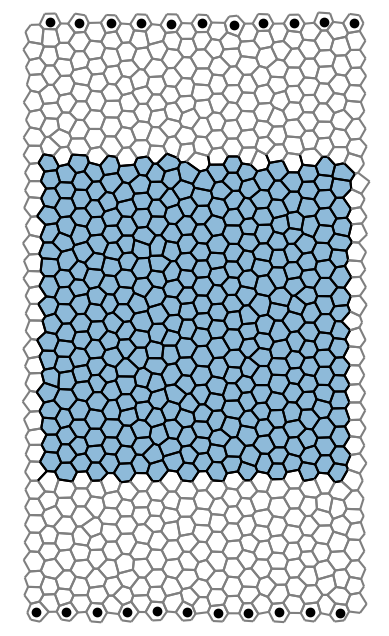

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors,
                      cell_colors=cell_colors_active)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

# add line to visualize the slip boundary
bdry_x, bdry_y = (property_dict['bdry_x'], property_dict['bdry_y'])
if mesh_initial.bdry_list:
    #plt.hlines((bdry_y-.25, -bdry_y+.25), (-9, -9), (9, 9), color="k")
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-bdry_x-.5, bdry_x+.5])
plt.ylim([-bdry_y-.5, bdry_y+.5])

plt.axis("off")

#plt.savefig("plots/initial_cond.pdf")

## set simulation parameters

In [ ]:
## feedback parameters

m = 4
k = .5
k_cutoff = .1 # regularization term to cut off excitable feedbacl
 
passive_ids = property_dict['passive_faces']
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1} # tension relaxation rate in passive region
    return {"k": k, "m": 4, "k_cutoff": k_cutoff}

params_no_pattern = {"k": k, "m": m, "k_cutoff": k_cutoff}
    
dt = .005 # time step
n_steps = 20
forbid_reflip = 20 # numerical constant - forbid a re-flip on an edge that just collapsed for some time steps
                   # (because the edge is still very short, albeit extending, it would be detected as intercalating)
                   # More systematic treatment would check if a short junction is extending/contracting to determine
                   # whether it needs to be flipped.

minimal_l = .075 # minimal edge length, lower edge lengths trigger T1

tri_mod_area = .01 # triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 100000)  #1e-4
mod_bulk = 1
mod_shear = 0 #.25 # .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = (1e-3, 1e-4)  # mollifying parameters to ensure energy differentiability

A0 = jnp.sqrt(3)/2
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # 2

passive_cells = property_dict['passive_cells']
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area, "P0": P0, "mod_perimeter": mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 1

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in property_dict['passive_cells']:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0
    ## other option: just relax to isotropic
    #delta = v.rest_shape-v.get_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

Few if any JIT-recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = False
save_dir = "runs/germ_band_test"
if save:
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        print('Warning: directory exists')

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(len(meshes)-1, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
                    rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    if flipped and not failed_flip:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])

  0%|          | 0/20 [00:00<?, ?it/s]

tpt 10: flip [1129, 1443]
tpt 13: flip [1186]
tpt 15: flip [1116, 135]
tpt 16: flip [631, 469]
tpt 17: flip [181, 886, 1173]
tpt 19: flip [1138, 1009]


In [ ]:
# just for convenience, save ids of T1s at each time. The T1s at each timepoint can also be reconstructed
# from the meshes if necessary.

last_flipped_edges.append([]) 
with open(f'{save_dir}/last_flipped_edges.pickle', 'wb') as handle:
    pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
meshes[-1].is_consistent()

True

### Loading a saved simulation

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

save_dir = 'runs/germ_band_test'
meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{save_dir}/{str(i).zfill(4)}_mesh', ) for i in tqdm(range(0, 99, 2))]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
meshes[-1].is_consistent()

True

# Analysis

Shows several types of plots

### Slider plots

Most importantly, visualize the mesh interactively

In [ ]:
#| export

def plot_mesh(i, xlim, ylim, mesh_series, flipped_series=None,
              edge_colors=None, cell_colors=None, slipwall_y=None, plot_cell=True, plot_tri=False):
    """
    Plot time series of meshes (simulation results).
    
    This function is used primarily for interactive slider plots, and to create movies.
    Usage example, using widget.fixed to set the args you do not want to tune interactively:
    
    fig = plt.figure(figsize=(6, 6))
    widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), edge_colors=None, cell_colors=None,
                 mesh_series=widgets.fixed(meshes), flipped_series=widgets.fixed(last_flipped_edges));
    
    Parameters
    ----------
    i: int
        Time point to plot
    xlim, ylim: float
        x- and y- limits of the axes, symmetric about 0.
    mesh_series, flipped_series: list
        Time series of meshes and T1 events, as given by simulation loop
    edge_colors, cell_colors: dict
        color dict, see mesh.cell_plot
    slipwall_y: float or None
        If float, plot slip walls at top/bottom at this position. If None, don't plot anything. 
    plot_cell, plot_tri: bool
        plot cells and/or triangulation
    """
    
    plt.cla()
    if slipwall_y is not None:
        plt.hlines((bdry_y, -bdry_y), (-xlim, -xlim), (xlim, xlim), color="k")
    plt.xlim([-xlim, xlim])
    plt.ylim([-ylim, ylim])
    plt.gca().set_aspect("equal", adjustable="box")
    if plot_cell:
        mesh_series[i].cellplot(edge_colors=edge_colors,
                                cell_colors=cell_colors)
    #meshes[i].labelplot(halfedge_labels=True, vertex_labels=True, face_labels=False)
    if plot_tri:
        mesh_series[i].triplot()
    if flipped_series:
        for x in flipped_series[i+1]:
            he = meshes[i].hes[x]
            if plot_cell:
                line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
                plt.plot(*line.T, c="r", lw=4)
            if plot_tri:
                line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
                plt.plot(*line.T, c="tab:purple", lw=5)

<IPython.core.display.Javascript object>


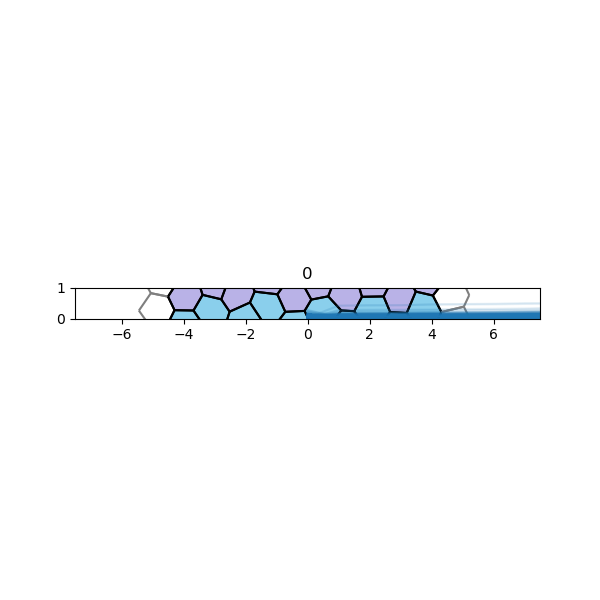

interactive(children=(IntSlider(value=10, description='i', max=20), FloatSlider(value=7.5, description='xlim',…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
    
# fix the arguments which you do not need to tune with widgets.fixed

widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(bdry_y),
                 edge_colors=widgets.fixed(edge_colors), cell_colors=widgets.fixed(cell_colors_active),
                 mesh_series=widgets.fixed(meshes),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );


### Rendering movies of triangulation and cells

In [ ]:
# cells

def plot_cells(i):
    plot_mesh(i, xlim=22,
    ylim=bdry_y+1, slipwall_y=None,
    edge_colors=edge_colors, cell_colors=cell_colors_active,
    mesh_series=meshes, flipped_series=None)
    
    for key in mesh_initial.bdry_list[0][1]+mesh_initial.bdry_list[1][1]:
        plt.scatter(*meshes[i].vertices[key].get_centroid(), c="k")
    plt.axis("off")
    
edge_colors = {key: "tab:grey" for key in property_dict['passive_edges']}

In [ ]:
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
plot_cells(0)


In [ ]:
#| notest
%matplotlib inline

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
nframes, frame_dt = 200, 500  

# run the animation
anim = animation.FuncAnimation(fig, plot_cells, frames=nframes, interval=frame_dt, repeat=False)
#anim.save('plots/cells_large.mp4', fps=10,)

In [ ]:
# triangulations

face_colors_active = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                      for key in mesh_initial.faces.keys()
                      if not key in property_dict['passive_faces']}

edge_colors = {key: np.array([0.8, 0.2, 0, .2]) if (key in property_dict['passive_edges']
                                                    or mesh_initial.hes[key].is_bdry())
               else np.array([0.8, 0.2, 0, 1]) for key in mesh_initial.hes.keys()}

def plot_tris(i):
    plt.cla()
    meshes[i].triplot_color(edge_colors=edge_colors, lw=1)
    plt.gca().set_aspect("equal", adjustable="box");
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlim([-22, 22])
    plt.ylim([-bdry_y-.5, bdry_y+.5])
    plt.axis("off")

In [ ]:
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))

plot_tris(0)


In [ ]:
#| notest
%matplotlib inline


# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300, figsize=(8,8))
nframes, frame_dt = 200, 500  

# run the animation
anim = animation.FuncAnimation(fig, plot_tris, frames=nframes, interval=frame_dt, repeat=False)
#anim.save('plots/tris_large.mp4', fps=10,)

### Energies & areas

These are mainly useful as numeric diagnostics. Energy vs time also has some independent interest.

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energies(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

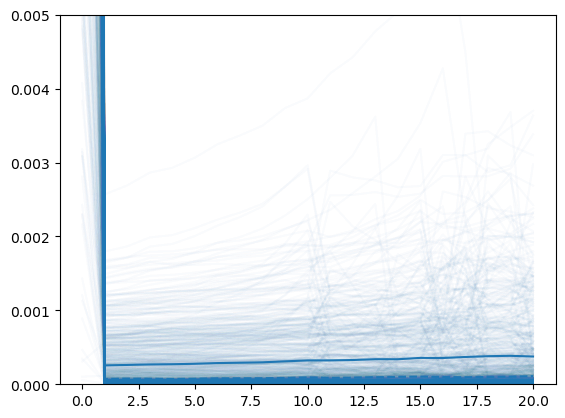

In [ ]:
## time series plot of angle penalties - sin(deviation from triangulation angle)

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.005);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 1.0)

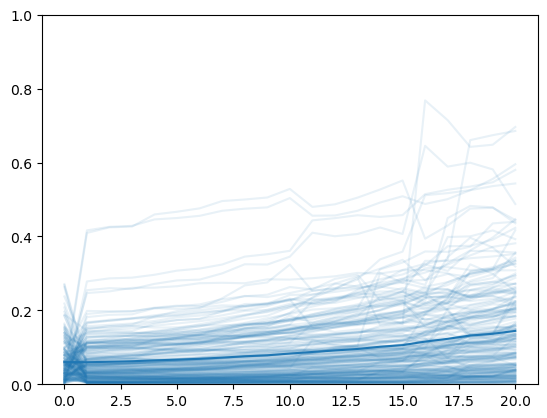

In [ ]:
## time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()
                   if not key in property_dict['passive_cells']])
#plt.plot(e_time.T, color="tab:blue", alpha=.1);
mean = e_time.mean(axis=0)
err_down, err_up = (np.quantile(e_time, .25, axis=0,), np.quantile(e_time, .75, axis=0,))

plt.plot(mean, color="tab:blue", alpha=1);
plt.fill_between(np.arange(e_time.shape[1]), err_down, err_up,
         color="tab:blue", alpha=.25);

plt.xlabel('Simulation step')
plt.ylabel('Elastic energy/cell (active cells only)')

plt.xlim([0, 171])
plt.ylim([0, 1.25*1e0])

#plt.savefig('plots/for_figure_v2/energy_vs_time_quartile_error.pdf', bbox_inches='tight')

<matplotlib.collections.PathCollection>

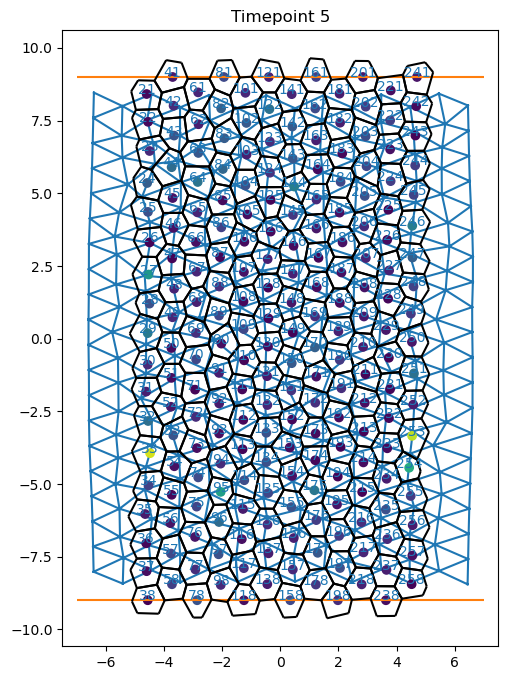

In [ ]:
## spatial plot of shape energies

i = 40

fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(f'Timepoint {i}');

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([meshes[i].vertices[key].get_centroid(), [val]])
                      for key, val in energies[i].items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.5)

(0.0, 1.7320508075688772)

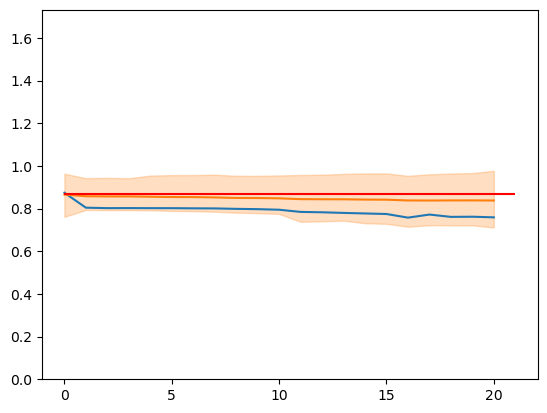

In [ ]:
# create and plot time-series of cell areas

areas = np.stack([[x for x in mesh.get_areas().values() if x is not None] for mesh in meshes])

plt.plot(areas[:, 3]) # an example trajectory
mean = areas.mean(axis=1)
plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(np.sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, np.sqrt(3)])

### Measure the amount of tissue extension

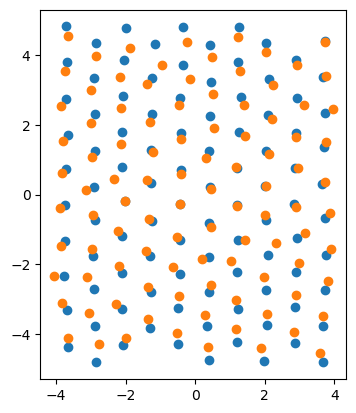

In [ ]:
# overlay initial and final positions of active cell vertices

centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                       if key not in passive_cells and not v.is_bdry()] for mesh in meshes[1:]])

plt.scatter(*centroids[5].T, label='intial cell centroids')
plt.scatter(*centroids[70].T, label='final cell centroids')
plt.legend(loc=(.1, 1.02))

plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
# compute width and height. could also use the inertia tensors of the centroid cloud, or any other number of things

sigma = 2

delta = np.quantile(centroids, axis=1, q=.9)-np.quantile(centroids, axis=1, q=.1,)
delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
delta_smooth /= delta_smooth[0]
delta_smooth = np.log(delta_smooth)

delta_log = np.log(delta_smooth)

[<matplotlib.lines.Line2D>]

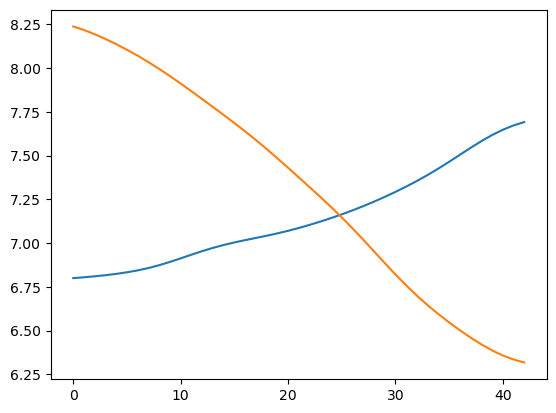

In [ ]:
# plot width and height

time = np.arange(delta_smooth.shape[0])

plt.plot(time, delta_log[:,1], label='m=4', color='tab:blue')
plt.plot(time, delta_log[:,1], label='m=1.5', color='tab:orange')

plt.yticks([-np.log(2), 0, np.log(2)], ["1/2", 1, "2"]);
plt.xticks([])

plt.xlabel('Simulation time')
plt.ylabel('x-fold change')
plt.legend()

### Plot cell trajectories, color-coded by time

In [ ]:
#| export

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def colorline(x, y, z=None, cmap='cool', norm=plt.Normalize(0.0, 1.0),
              linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm,
                        linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [ ]:
# example of colored line

x = np.linspace(0, 4. * np.pi, 100)
y = np.sin(x)
fig, ax = plt.subplots()
lc = colorline(x, y, cmap='hsv')
plt.colorbar(lc)
plt.xlim(x.min(), x.max())
plt.ylim(-1.0, 1.0)
plt.show()

In [ ]:
trajectories = [[val.get_centroid() for key, val in mesh.vertices.items()
                if (not mesh_initial.vertices[key].is_bdry())] for mesh in meshes[1:]]

trajectories = np.stack(trajectories).transpose((1,0,2))

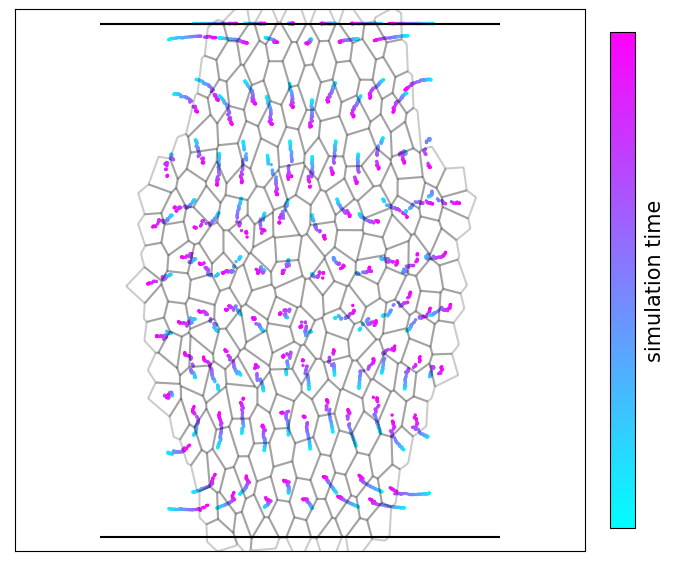

In [ ]:
fig = plt.figure(figsize=(8,8))

t = np.arange(trajectories.shape[1])

stop = 4

for traj in trajectories[::2]:
    plt.scatter(*ndimage.gaussian_filter1d(traj[:stop].T, axis=1, sigma=2), s=2, c=t[:stop], cmap="cool")
    colorline(*ndimage.gaussian_filter1d(traj[:stop].T, axis=1, sigma=2), cmap="cool")

cb = plt.colorbar(fraction=0.04, pad=0.04)
cb.set_ticks([])
cb.set_label(label='simulation time', fontsize=15)

#meshes[stop].cellplot(alpha=.2)

plt.xticks([],[])
plt.yticks([],[])

#plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="black", label="slip wall")
plt.xlim([-14, 14])
plt.ylim([-bdry_y-.5, bdry_y+.5])
plt.gca().set_aspect("equal", adjustable="box")

#plt.savefig("plots/for_figure_v3/trajectories.pdf")

### Plot small snapshots

In [ ]:
#| notest
def plot_snapshot(i, xlim, ylim):
    plt.cla()
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors={}, cell_colors=cell_colors)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xticks([],[])
    plt.yticks([],[])

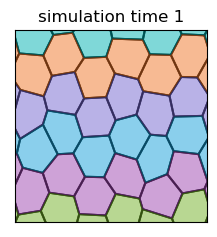

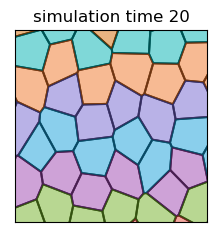

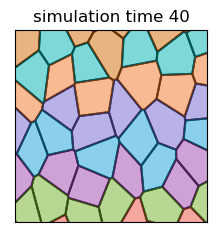

In [ ]:
for i in [1, 40, 100]:
    fig = plt.figure(figsize=(2.5, 2.5))
    plot_snapshot(i, xlim=[-2.5, 2.5], ylim=[-4, 1])
    #plt.savefig(f"plots/for_figure_v3/snapshot_time_{i}.pdf")
    plt.title(f'simulation time {i}')
    plt.show()


### Analysis junction collapse and elongation during T1s

Could also look at junctional tensions etc

In [ ]:
# collect all junction lengths
length_dicts = [x.get_primal_edge_lens() for x in meshes]

# align on T1 transitions using the saved ids of T1s during simulation.

lengths_stacked = []
for i in range(35, 43):
    for e in last_flipped_edges[i]:
        if not e in property_dict['passive_edges']:
            length = np.stack([x[e] for x in length_dicts])
            lengths_stacked.append(length[i-35:i+35])
            
lengths_stacked = np.stack(lengths_stacked)

In [ ]:
# T1 can also be reconstructed easily by looking at edges which change vertex ids at any given time

flipped = [[key for key in meshes[t].hes.keys() 
            if [v._vid for v in meshes[t].hes[key].vertices] != [v._vid for v in meshes[t+1].hes[key].vertices]]
            for t in range(0, 70)] + []


In [ ]:
time = .27*(np.arange(lengths_stacked.shape[1]) - 35.)  #.28

length_scale = 8.5  # 8.5

mean = (lengths_stacked.mean(axis=0)) * length_scale
std = lengths_stacked.std(axis=0) * length_scale

plt.plot(time, mean, color='tab:blue', label=r'...')
plt.fill_between(time, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.plot(time, mean_control-mean_control.min(), color='tab:orange', label='control')

plt.xlim([-10, 10])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 2, 4], fontsize=14)


plt.xlabel('time [min]', fontsize=14)
plt.ylabel('edge length [μm]', fontsize=14)
plt.legend(fontsize=14)

In [ ]:
## we can also look at the orientations of collapsing/extending junctions

collapsed = []
new = []

dt = 10

for i in range(35, 50):
    for e in last_flipped_edges[i]:
        if not meshes[0].hes[e].is_bdry():
            he = meshes[i-dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            collapsed.append(np.arctan2(*vector[::-1]))
            
            he = meshes[i+dt].hes[e]
            vector = he.face.primal_coords-he.twin.face.primal_coords
            vector *= vector[1]
            new.append(np.arctan2(*vector[::-1]))
            
collapsed = np.stack(collapsed)
new = np.stack(new)

# if desired, save
#np.savetxt("plots/for_figure_v2/collapsing_angle_control.txt", collapsed)
#np.savetxt("plots/for_figure_v2/extending_angle_control.txt", new)

In [ ]:
bins = np.arange(0, 181, 20)

plt.hist(collapsed*(180/np.pi), bins=bins, alpha=.5, label="collapsing", density=True)
plt.hist(new*(180/np.pi), bins=bins, alpha=.5, label="extending", density=True)

plt.xticks(np.arange(0, 181, 30), fontsize=14)
plt.yticks(np.linspace(0, 0.01, 3), 1e2*np.linspace(0, 0.01, 3), fontsize=14)

plt.xlabel("Junction orientation", fontsize=16)
plt.ylabel(r"Probability density [$x10^{-2}$]", fontsize=16)

plt.legend(fontsize=16)

### Vertex-model order parameter

Measure the ratio of perimeter and area: $P/\sqrt{A}$. A measure of tissue disorder.

In [ ]:
#| export

def get_p_over_sqrt_A(v: msh.Vertex) -> float:
    """Compute perimeter/sqrt(area) of cell. Returns None for boundary cells."""
    if v.is_bdry():
        return None
    return tns.polygon_perimeter(v.primal_coords) / np.sqrt(tns.polygon_area(v.primal_coords))

In [ ]:
get_p_over_sqrt_A(meshes[10].vertices[70])

DeviceArray(3.81823002, dtype=float64)

In [ ]:
P_over_A = np.stack([[get_p_over_sqrt_A(v) for key, v in mesh.vertices.items()
                      if key not in passive_cells and not v.is_bdry()] for mesh in meshes[1:]])

<matplotlib.legend.Legend>

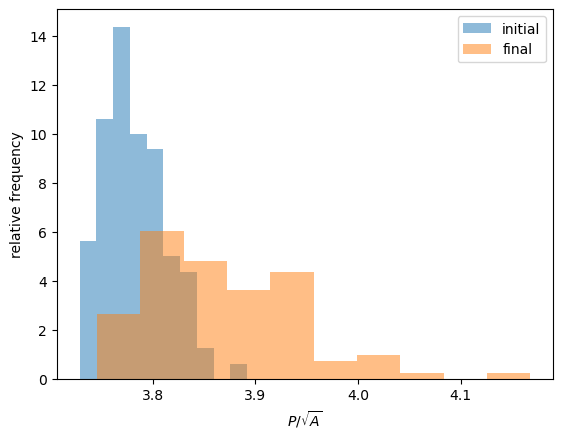

In [ ]:
plt.hist(P_over_A[0], alpha=.5, label='initial', density=True, bins=10);
plt.hist(P_over_A[-1], alpha=.5, label='final', density=True, bins=10);

plt.xlabel(r'$P / \sqrt{A}$')
plt.ylabel('relative frequency')
plt.legend()

In [ ]:
# plot mean vs time

mean = np.median(P_over_A, axis=1)[:35]
std = P_over_A.std(axis=1)[:35]

plt.plot(np.arange(35), mean)
plt.fill_between(np.arange(35), mean-std, mean+std, color="tab:blue", alpha=.25)
plt.hlines( 3.813, 0, 35, ls="dashed", color="k")
plt.yticks([3.7, 3.813, 3.9, 4, 4.1], [3.7, 3.813, 3.9, 4.0, 4.1], fontsize=14)
plt.xticks([],[])
plt.ylim([3.7, 4.1])

plt.xlabel("Simulation time", fontsize=16)
plt.ylabel(r'shape index $P / \sqrt{A}$', fontsize=16)

### Stress anisotropy

In [ ]:
stress_tensors = [np.array([f.get_stress_tensor() for f in x.faces.values()
                  if (not f._fid in property_dict["passive_faces"]) and (not f.is_bdry())])
                  for x in meshes]

stress_tensors_dev  = [x - np.einsum('nii,jk->njk', x, np.eye(2))/2 for x in stress_tensors]

In [ ]:
mean_DV_DV = np.stack([x[:,1,1].mean() for x in stress_tensors_dev])
std_DV_DV = np.stack([x[:,1,1].std() for x in stress_tensors_dev])

median_DV_DV = np.array([np.median(x[:,1,1]) for x in stress_tensors_dev])
quartile_low_DV_DV = np.array([np.quantile(x[:,1,1], .25) for x in stress_tensors_dev])
quartile_high_DV_DV = np.array([np.quantile(x[:,1,1], .75) for x in stress_tensors_dev])

t = np.arange(mean_DV_DV.shape[0])

In [ ]:
plt.plot(t, median_DV_DV)
plt.fill_between(t, quartile_low_DV_DV, quartile_high_DV_DV, color="tab:blue", alpha=.25)


plt.xticks([],[])
plt.yticks([0, 0.2, 0.4], [0, 0.2, 0.4], fontsize=16)

plt.xlabel("Simulation time", fontsize=16)
plt.ylabel(r'Dev. stress DV/DV', fontsize=16)

## Dual shape factor distribution

Comparison point: experimental data

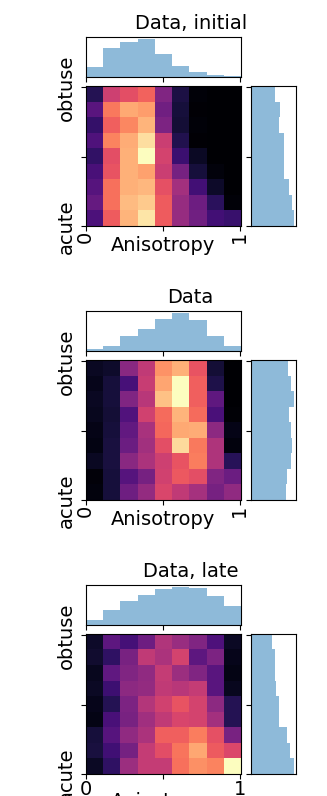

In [ ]:
angle_series = [mesh.get_vertex_angles(exclude=passive_ids, method="dual") for mesh in meshes[1:]]

dsf_series = np.stack([tns.angles_shape(np.array(list(x.values())).T) for x in angle_series])

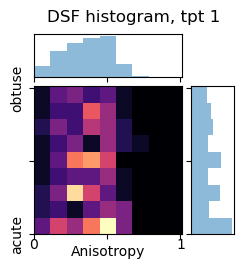

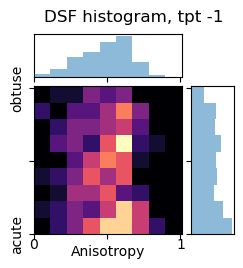

In [ ]:
for i in [1, -1]:

    fig = plt.figure(figsize=(2.5, 2.5))
    fig.suptitle(f'DSF histogram, tpt {i}', y=1.)

    bins = [dln.eqspace(0, 1+.01, .1), dln.eqspace(0, 1+.01, .1)]
    ax = dln.scatter_hist(dsf_series[i,1], dsf_series[i,0]/np.pi, bins, fig=fig)

    ax.set_ylabel("", labelpad=-5)
    ax.set_xlabel("Anisotropy", labelpad=-5)
    ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
    ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
    #ax.set_aspect('equal', adjustable='box')
    plt.show()

[<matplotlib.axis.XTick>,
 <matplotlib.axis.XTick>,
 <matplotlib.axis.XTick>]

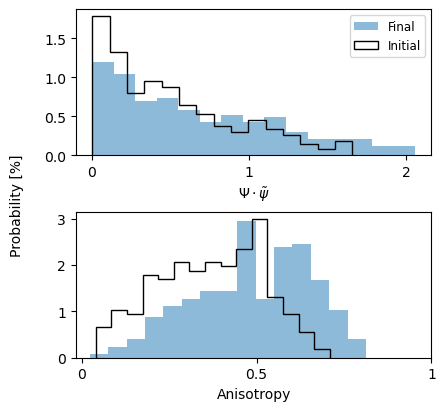

In [ ]:
## plot the "bridge" order parameter and anisotropy

fig, (ax1, ax2) = plt.subplots(figsize=(4,4), ncols=1, nrows=2, constrained_layout = True)

t_sim = -1
n_bins = 15

ax1.hist(np.prod(dsf_series[t_sim], axis=0), alpha=.5, bins=n_bins, density=True, label='Final');
ax1.hist(np.prod(dsf_series[1], axis=0), bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

ax1.set_xlabel(r"$\Psi\cdot\tilde{\psi}$",)
ax1.legend(fontsize=8.5)

ax2.hist(dsf_series[t_sim][1], alpha=.5, bins=n_bins, density=True, label='Final');
ax2.hist(dsf_series[2][1], bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

ax2.set_xlabel(r"Anisotropy")
fig.text(-0.075, 0.5, 'Probability [%]', va='center', rotation='vertical')

ax1.set_xticks([0, 1, 2], [0, 1, 2])
ax2.set_xticks([0, 0.5, 1,], [0, 0.5, 1,])